# Model Prototype

### Load Data

In [19]:
# load libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [20]:
class DataCleaner():

    def clean_uom_space(self,uom_space_df):
        uom_space_df['Campus Code']=uom_space_df['Campus Code'].astype(str).str.strip()
        uom_space_df['Building Code']=uom_space_df['Building Code'].astype(str).str.strip()
        uom_space_df['Building Name']=uom_space_df['Building Name'].astype(str).str.strip()
        uom_space_df['Room Type']=uom_space_df['Room Type'].astype(str).str.strip()
        uom_space_df['Room Category']=uom_space_df['Room Category'].astype(str).str.strip()
        uom_space_df['Floor Code']=uom_space_df['Floor Code'].astype(str).str.strip()
        uom_space_df['Room Code']=uom_space_df['Room Code'].astype(str).str.strip()
        return uom_space_df

    def clean_rm_category_type(self,rm_category_type_df):
        rm_category_type_df['Room Type']=rm_category_type_df['Room Type'].astype(str).str.strip()
        rm_category_type_df['Room Category']=rm_category_type_df['Room Category'].astype(str).str.strip()
        rm_category_type_df['Room Type Abbreviation']=rm_category_type_df['Room Type Abbreviation'].str.lower().str.strip()
        rm_category_type_df['Description']=rm_category_type_df['Description'].str.lower().str.strip()
        rm_category_type_df['Room Type Definition']=rm_category_type_df['Room Type Definition'].str.lower().str.strip()
        return rm_category_type_df

    def clean_floor_data(self,floor_df):
        floor_df['Building Code'] = floor_df['Building Code'].astype(str).str.strip()
        floor_df['Floor Code'] = floor_df['Floor Code'].astype(str).str.strip()
        floor_df['Floor Name'] = floor_df['Floor Name'].astype(str).str.strip()
        return floor_df

    def clean_em_location(self,em_location_df):
        em_location_df['Floor Code'] = em_location_df['Floor Code'].astype(int)
        em_location_df['Floor Code'] = em_location_df['Floor Code'].astype(str).str.strip()
        return em_location_df

    def clean_av_equipment(self,av_equipment_df):
        av_equipment_df['Room Type'] = av_equipment_df['Room Type'].astype(str).str.strip()
        av_equipment_df['Room Code'] = av_equipment_df['Room Code'].astype(str).str.strip()
        av_equipment_df['Building Code'] = av_equipment_df['Building Code'].astype(str).str.strip()
        av_equipment_df['Campus Code'] = av_equipment_df['Campus Code'].astype(str).str.strip()
        av_equipment_df['Equip. Status'] = av_equipment_df['Equip. Status'].astype(str).str.strip()
        av_equipment_df['Floor Code'] = av_equipment_df['Floor Code'].astype(int).astype(str).str.strip()
        return av_equipment_df

    def clean_timetable_data(self,timetable_df):
        # remove all NaN rows
        timetable_df = timetable_df.dropna(how='all')

        # drop duplicate records
        timetable_df = timetable_df.drop_duplicates()

        # dropping classes whose location is not planned
        timetable_df = timetable_df[timetable_df['Host Key of Allocated Locations'].notna()]

        # dropping classes whose location is online option
        timetable_df = timetable_df[timetable_df['Host Key of Allocated Locations']!='Online option.']

        # dropping classes with off-site location
        timetable_df = timetable_df[timetable_df['Name of Zone of Allocated Locations']!='Off-Site']
        return timetable_df

    def clean_meeting_room_usage(self,meeting_room_usage_df):
        meeting_room_usage_df = meeting_room_usage_df[meeting_room_usage_df['Campus Code'].notna()]
        meeting_room_usage_df = meeting_room_usage_df[meeting_room_usage_df['Building Code'].notna()]
        meeting_room_usage_df = meeting_room_usage_df[meeting_room_usage_df['Floor Code'].notna()]
        meeting_room_usage_df = meeting_room_usage_df[meeting_room_usage_df['Room Code'].notna()]

        meeting_room_usage_df['Campus Code'] = meeting_room_usage_df['Campus Code'].astype(str).str.strip()
        meeting_room_usage_df['Building Code'] = meeting_room_usage_df['Building Code'].astype(str).str.strip()
        meeting_room_usage_df['Building Name'] = meeting_room_usage_df['Building Name'].astype(str).str.strip()
        meeting_room_usage_df['Floor Code'] = meeting_room_usage_df['Floor Code'].astype(int).astype(str).str.strip()
        meeting_room_usage_df['Room Code'] = meeting_room_usage_df['Room Code'].astype(str).str.strip()
        return meeting_room_usage_df

In [21]:
class DataMutator():

    def mutate_em_location(self,em_location_df):
        # mutate room codes
        for idx,row in em_location_df.iterrows():
            if "." in row['Room Code']:
                code = row['Room Code'].split(".")[0]
                em_location_df.at[idx,'Room Code'] = code
        return em_location_df

    def mutate_timetable_data(self,timetable_df):
        building_codes = []
        room_codes = []
        campus_codes = []
        class_duration_minutes = []
        for idx,row in timetable_df.iterrows():
            s = row['Host Key of Allocated Locations'].split('-')
            building_codes.append(s[0])
            room_codes.append(s[1])
            c = row['Name of Allocated Locations'].split('-')[0]
            if c == 'zzzPAR':
                c = 'PAR'
            campus_codes.append(c)
            d = row['Duration as duration']
            class_duration_minutes.append(d.hour * 60 + d.minute)
        timetable_df['Building Code'] = building_codes
        timetable_df['Room Code'] = room_codes
        timetable_df['Campus Code'] = campus_codes
        timetable_df['Class Duration In Minutes'] = class_duration_minutes
        return timetable_df

In [22]:
class DataMerger():

    def get_merged_space_data(self,uom_space_df,rm_category_type_df, floor_df):
        uom_space_df_enhanced = pd.merge(uom_space_df,floor_df,on=['Building Code','Floor Code'])
        print("# Merge - uom_space + floor_data")
        print((uom_space_df.shape, uom_space_df_enhanced.shape))
        print('Unable to merge records:',uom_space_df.shape[0]-uom_space_df_enhanced.shape[0])
        merged_space_data_df = pd.merge(uom_space_df_enhanced,rm_category_type_df,on=['Room Category','Room Type'])
        print("# Merge - enhanced_uom_space + rm_category_type")
        print((uom_space_df_enhanced.shape, merged_space_data_df.shape))
        print('Unable to merge records:',uom_space_df_enhanced.shape[0]-merged_space_data_df.shape[0])
        return merged_space_data_df

    def get_merged_em_location_data(self,em_location_df,merged_space_data_df):
        print("# merge - space_data + em_location")
        merged_em_location_df = pd.merge(em_location_df,merged_space_data_df,on=['Building Code','Floor Code','Room Code'])
        print((em_location_df.shape, merged_em_location_df.shape))
        print('Unable to merge records:',em_location_df.shape[0]-merged_em_location_df.shape[0])
        return merged_em_location_df

    def get_merged_av_equipment_data(self,av_equipment_df,merged_space_data_df):
        print("# merge - space_data + av_equipment")
        merged_av_equipment_df = pd.merge(av_equipment_df,merged_space_data_df,on=['Campus Code','Building Code','Floor Code','Room Code'])
        print((av_equipment_df.shape, merged_av_equipment_df.shape))
        print('Unable to merge records:',av_equipment_df.shape[0]-merged_av_equipment_df.shape[0])
        return merged_av_equipment_df

    def get_merged_timetable_data(self,timetable_df,merged_space_data_df):
        print("# merge - space_data + timetable_data")
        merged_timetable_df = pd.merge(timetable_df,merged_space_data_df,on=['Campus Code','Building Code','Room Code'])
        print((timetable_df.shape, merged_timetable_df.shape))
        print('Unable to merge records:',timetable_df.shape[0]-merged_timetable_df.shape[0])
        return merged_timetable_df

    def get_merged_meeting_room_usage_data(self,meeting_room_usage_df,merged_space_data_df):
        print("# merge - space_data + meeting_room_usage")
        merged_meeting_room_usage_df = pd.merge(meeting_room_usage_df,merged_space_data_df,on=['Campus Code','Building Code','Floor Code','Room Code'])
        print((meeting_room_usage_df.shape, merged_meeting_room_usage_df.shape))
        print('Unable to merge records:',meeting_room_usage_df.shape[0]-merged_meeting_room_usage_df.shape[0])
        return merged_meeting_room_usage_df

In [23]:
class DataProcessor():
    def __init__(self,uom_space_url,rm_category_type_url,
                 em_location_url,av_equipment_url,
                 timetable_2020_url,floor_name_url,
                 meeting_room_usage_url):
        self.uom_space_url = uom_space_url
        self.rm_category_type_url = rm_category_type_url
        self.em_location_url = em_location_url
        self.av_equipment_url = av_equipment_url
        self.timetable_2020_url = timetable_2020_url
        self.floor_name_url = floor_name_url
        self.meeting_room_usage_url = meeting_room_usage_url

    def load_data(self):
        self.uom_space_df = pd.read_excel(uom_space_url)
        self.rm_category_type_df = pd.read_excel(rm_category_type_url)
        self.em_location_df = pd.read_excel(em_location_url)
        self.av_equipment_df = pd.read_excel(av_equipment_url)
        self.timetable_df = pd.read_excel(timetable_2020_url, delim_whitespace=True)
        self.floor_df = pd.read_excel(floor_name_url)
        self.meeting_room_usage_df = pd.read_excel(meeting_room_usage_url)
        print('Data loaded successfully!')
        # data shapes
        print("UOM space shape:"+str(self.uom_space_df.shape))
        print("RM category:"+str(self.rm_category_type_df.shape))
        print("EM location:"+str(self.em_location_df.shape))
        print("AV equipment:"+str(self.av_equipment_df.shape))
        print("2020 timetable:"+str(self.timetable_df.shape))
        print("Floor data shape:"+str(self.floor_df.shape))
        print("Meeting room usage shape:"+str(self.meeting_room_usage_df.shape))

    def get_all_datasets(self):

        print("# clean data")
        _cleaner = DataCleaner()
        self.uom_space_df = _cleaner.clean_uom_space(self.uom_space_df)
        self.rm_category_type_df = _cleaner.clean_rm_category_type(self.rm_category_type_df)
        self.floor_df = _cleaner.clean_floor_data(self.floor_df)
        self.em_location_df = _cleaner.clean_em_location(self.em_location_df)
        self.av_equipment_df = _cleaner.clean_av_equipment(self.av_equipment_df)
        self.timetable_df = _cleaner.clean_timetable_data(self.timetable_df)
        self.meeting_room_usage_df = _cleaner.clean_meeting_room_usage(self.meeting_room_usage_df)

        print("# mutate data")
        _mutator = DataMutator()
        self.em_location_df = _mutator.mutate_em_location(self.em_location_df)
        self.timetable_df = _mutator.mutate_timetable_data(self.timetable_df)

        print("# merge data")
        _merger = DataMerger()
        self.merged_space_data = _merger.get_merged_space_data(self.uom_space_df, self.rm_category_type_df, self.floor_df)
        self.merged_em_location_data = _merger.get_merged_em_location_data(self.em_location_df,self.merged_space_data)
        self.merged_av_equipment_data = _merger.get_merged_av_equipment_data(self.av_equipment_df,self.merged_space_data)
        self.merged_timetable_data = _merger.get_merged_timetable_data(self.timetable_df,self.merged_space_data)
        self.merged_meeting_room_usage_data = _merger.get_merged_meeting_room_usage_data(self.meeting_room_usage_df,self.merged_space_data)

        return self.merged_space_data, self.merged_em_location_data, self.merged_av_equipment_data, self.merged_timetable_data, self.merged_meeting_room_usage_data

In [24]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# local urls
uom_space_url = '/content/drive/My Drive//project-data/uom-space.xlsx'
rm_category_type_url = '/content/drive/My Drive/project-data/rm-category-type-cleaned.xlsx'
em_location_url = '/content/drive/My Drive/project-data/em-location.xlsx'
av_equipment_url = '/content/drive/My Drive/project-data/av-equipment.xlsx'
timetable_2020_url = '/content/drive/My Drive/project-data/2020-timetable-v2.xlsx'
floor_name_url = '/content/drive/My Drive/project-data/fl-name-cleaned.xlsx'
meeting_room_usage_url = '/content/drive/My Drive/project-data/meeting-room-usage.xlsx'

In [26]:
# load data
_processor = DataProcessor(uom_space_url,rm_category_type_url,em_location_url,av_equipment_url,
                           timetable_2020_url,floor_name_url,meeting_room_usage_url)
_processor.load_data()

Data loaded successfully!
UOM space shape:(22166, 14)
RM category:(209, 5)
EM location:(7709, 4)
AV equipment:(1964, 11)
2020 timetable:(131857, 23)
Floor data shape:(1369, 3)
Meeting room usage shape:(1462, 22)


In [27]:
# get datasets - after cleaning, mutation and merging
space_data, employee_data, av_equipment_data, timetable_data, mr_usage_data = _processor.get_all_datasets()

# clean data
# mutate data
# merge data
# Merge - uom_space + floor_data
((22166, 14), (22166, 15))
Unable to merge records: 0
# Merge - enhanced_uom_space + rm_category_type
((22166, 15), (22166, 18))
Unable to merge records: 0
# merge - space_data + em_location
((7709, 4), (6962, 19))
Unable to merge records: 747
# merge - space_data + av_equipment
((1964, 11), (1646, 25))
Unable to merge records: 318
# merge - space_data + timetable_data
((119419, 27), (116981, 42))
Unable to merge records: 2438
# merge - space_data + meeting_room_usage
((890, 22), (728, 36))
Unable to merge records: 162


In [28]:
class DataExtractor():

    def get_meeting_rooms_data(self,rm_category_type_df,space_data):
        # possible meeting rooms
        possible_rooms = rm_category_type_df[rm_category_type_df['Room Type'].str.contains("601|629")]
        meeting_room_types = possible_rooms['Room Type'].tolist()

        # supply of meeting rooms
        possible_meeting_rooms_df = space_data[space_data['Room Type'].isin(meeting_room_types)]
        return possible_meeting_rooms_df

    def get_toilets_data(self,rm_category_type_df,space_data):
        possible_rooms = rm_category_type_df[rm_category_type_df['Room Type Definition'].str.contains("toilet|washroom")]
        toilet_room_types = possible_rooms['Room Type'].tolist()

        possible_toilets_df = space_data[space_data['Room Type'].isin(toilet_room_types)]
        return possible_toilets_df

In [29]:
_extractor = DataExtractor()
possible_meeting_rooms_data = _extractor.get_meeting_rooms_data(_processor.rm_category_type_df, space_data)
possible_toilets_data = _extractor.get_toilets_data(_processor.rm_category_type_df, space_data)

## Floor based prediction model

In [30]:
space_data.head(5)

,Campus Code,Building Code,Building Name,Floor Code,Room Code,Room Name,Room Category,Room Type,Room Type Abbreviation_x,Room Capacity,Room Area m²,Room Condition 2018,Department Code,Room Location Code,Floor Name,Room Type Abbreviation_y,Description,Room Type Definition
0,PAR,101,BEAUREPAIRE CENTRE,0,CG01,NaN,6,631,Circ-Department,0.0,80.62,NaN,8490,PAR;101;0;CG01,Ground,circ-department,circulation - department,a corridor allocated to a specific faculty tha...
1,PAR,101,BEAUREPAIRE CENTRE,0,CG03,NaN,6,631,Circ-Department,0.0,14.12,NaN,8490,PAR;101;0;CG03,Ground,circ-department,circulation - department,a corridor allocated to a specific faculty tha...
2,PAR,101,BEAUREPAIRE CENTRE,1,C101,NaN,6,631,Circ-Department,0.0,5.79,NaN,8490,PAR;101;1;C101,Level 1,circ-department,circulation - department,a corridor allocated to a specific faculty tha...
3,PAR,101,BEAUREPAIRE CENTRE,1,C102,NaN,6,631,Circ-Department,0.0,5.77,NaN,8490,PAR;101;1;C102,Level 1,circ-department,circulation - department,a corridor allocated to a specific faculty tha...
4,PAR,101,BEAUREPAIRE CENTRE,1,C103,NaN,6,631,Circ-Department,0.0,23.87,NaN,8490,PAR;101;1;C103,Level 1,circ-department,circulation - department,a corridor allocated to a specific faculty tha...


In [31]:
space_data.columns

Index(['Campus Code', 'Building Code', 'Building Name', 'Floor Code',
       'Room Code', 'Room Name', 'Room Category', 'Room Type',
       'Room Type Abbreviation_x', 'Room Capacity', 'Room Area m²',
       'Room Condition 2018', 'Department Code', 'Room Location Code',
       'Floor Name', 'Room Type Abbreviation_y', 'Description',
       'Room Type Definition'],
      dtype='object')

In [32]:
# find out the number of meeting rooms with excellent, very good, good condition
import numpy as np
possible_meeting_rooms_data["Good Condition"] = np.where((possible_meeting_rooms_data['Room Condition 2018'] == "Excellent") | 
                                          (possible_meeting_rooms_data['Room Condition 2018'] == "Very Good")|
                         (possible_meeting_rooms_data['Room Condition 2018'] == "Good"), 1, 0)

In [33]:
building_code = '104'

In [34]:
# alan gilbert building
data_104 = space_data[space_data['Building Code']==building_code]
data_104.shape

(486, 18)

In [35]:
possible_floors_104 = data_104.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({'Room Code':pd.Series.nunique})
possible_floors_104

,Floor Code,Floor Name,Room Code
0,0,Ground,35
1,0.1,Basement 1,19
2,0.5,Ground Mezzanine,2
3,1,Level 1,45
4,2,Level 2,74
5,3,Level 3,38
6,4,Level 4,73
7,5,Level 5,62
8,6,Level 6,63
9,7,Level 7,57


In [36]:
meeting_rooms_104 = possible_meeting_rooms_data[possible_meeting_rooms_data['Building Code']==building_code]
meeting_rooms_104.shape

(33, 19)

In [37]:
room_condition_104 = meeting_rooms_104.groupby(by=['Floor Code','Floor Name','Room Condition 2018'],as_index=False).agg({'Room Code':pd.Series.nunique})

In [38]:
room_condition_104

,Floor Code,Floor Name,Room Condition 2018,Room Code
0,1,Level 1,Excellent,2
1,2,Level 2,Good,5
2,3,Level 3,Good,1
3,4,Level 4,Excellent,12
4,5,Level 5,Excellent,8
5,6,Level 6,Excellent,3
6,7,Level 7,Excellent,2


In [39]:
meeting_rooms_104.groupby(by = ['Floor Code','Floor Name'], as_index=False).agg({'Good Condition':sum, 'Room Capacity':sum})

,Floor Code,Floor Name,Good Condition,Room Capacity
0,1,Level 1,2,8.0
1,2,Level 2,5,58.0
2,3,Level 3,1,6.0
3,4,Level 4,12,76.0
4,5,Level 5,8,84.0
5,6,Level 6,3,16.0
6,7,Level 7,2,33.0


In [40]:
# props of good condition meeting rooms
meeting_rooms_104_by_floor = meeting_rooms_104.groupby(by = ['Floor Code','Floor Name'], as_index=False).agg({'Good Condition':sum, 'Room Capacity':sum, 'Room Code':pd.Series.nunique})
meeting_rooms_104_by_floor['props']  = meeting_rooms_104_by_floor['Good Condition']/meeting_rooms_104.shape[0]
meeting_rooms_104_by_floor

,Floor Code,Floor Name,Good Condition,Room Capacity,Room Code,props
0,1,Level 1,2,8.0,2,0.060606
1,2,Level 2,5,58.0,5,0.151515
2,3,Level 3,1,6.0,1,0.030303
3,4,Level 4,12,76.0,12,0.363636
4,5,Level 5,8,84.0,8,0.242424
5,6,Level 6,3,16.0,3,0.090909
6,7,Level 7,2,33.0,2,0.060606


In [41]:
meeting_rooms_104_by_floor['Room Code'].sum()

33

In [42]:
meeting_rooms_104_by_floor[meeting_rooms_104_by_floor['Floor Code']=='1']

,Floor Code,Floor Name,Good Condition,Room Capacity,Room Code,props
0,1,Level 1,2,8.0,2,0.060606


In [43]:
em_104 = employee_data[employee_data['Building Code']==building_code]
em_104.shape

(329, 19)

In [44]:
em_104_by_floor = em_104.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Employee Sequential ID':pd.Series.nunique})
em_104_by_floor['props']  = em_104_by_floor['Employee Sequential ID']/em_104.shape[0]
em_104_by_floor

,Floor Code,Floor Name,Employee Sequential ID,props
0,0,Ground,10,0.030395
1,1,Level 1,29,0.088146
2,2,Level 2,61,0.185410
3,4,Level 4,68,0.206687
4,5,Level 5,40,0.121581
5,6,Level 6,76,0.231003
6,7,Level 7,45,0.136778


In [45]:
av_equipment_data.columns

Index(['Equipment Code', 'Equipment Standard', 'Manufacturer', 'Equip. Status',
       'Building Code', 'Floor Code', 'Room Code', 'Campus Code',
       'Room Type_x', 'Room Type Abbreviation', 'Room Category_x',
       'Building Name', 'Room Name', 'Room Category_y', 'Room Type_y',
       'Room Type Abbreviation_x', 'Room Capacity', 'Room Area m²',
       'Room Condition 2018', 'Department Code', 'Room Location Code',
       'Floor Name', 'Room Type Abbreviation_y', 'Description',
       'Room Type Definition'],
      dtype='object')

In [46]:
# get meeting room equipment data
meetingroom_equipment = av_equipment_data[av_equipment_data['Room Type_x'].str.contains("601|629")]
# find out number of equip. in use
meetingroom_equipment["Usable Equip."] = np.where((meetingroom_equipment['Equip. Status'] == "In service"), 1, 0)

equipment_104 = meetingroom_equipment[meetingroom_equipment['Building Code']==building_code]

In [47]:
equipment_104.columns

Index(['Equipment Code', 'Equipment Standard', 'Manufacturer', 'Equip. Status',
       'Building Code', 'Floor Code', 'Room Code', 'Campus Code',
       'Room Type_x', 'Room Type Abbreviation', 'Room Category_x',
       'Building Name', 'Room Name', 'Room Category_y', 'Room Type_y',
       'Room Type Abbreviation_x', 'Room Capacity', 'Room Area m²',
       'Room Condition 2018', 'Department Code', 'Room Location Code',
       'Floor Name', 'Room Type Abbreviation_y', 'Description',
       'Room Type Definition', 'Usable Equip.'],
      dtype='object')

In [48]:
equipment_by_floor = equipment_104.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Usable Equip.':sum})

equipment_by_floor["props"] = equipment_by_floor['Usable Equip.']/equipment_104.shape[0]

In [49]:
equipment_by_floor

,Floor Code,Floor Name,Usable Equip.,props
0,4,Level 4,1,0.5
1,6,Level 6,1,0.5


In [66]:
from scipy.special import softmax
def get_MR_scores_for_floors(floor_position, building_code, required_capacity, penalty=0.05):
    data = space_data[space_data['Building Code']==building_code]
    possible_floors = data.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({'Room Code':pd.Series.nunique})
    print(possible_floors)

    meeting_rooms = possible_meeting_rooms_data[possible_meeting_rooms_data['Building Code']==building_code]
    meeting_rooms_by_floor = meeting_rooms.groupby( by = ['Floor Code','Floor Name'], as_index=False).agg({'Good Condition':sum, 'Room Capacity':sum, 'Room Code':pd.Series.nunique})
    meeting_rooms_by_floor = meeting_rooms_by_floor[meeting_rooms_by_floor["Room Capacity"] >= required_capacity]
    total_rooms = meeting_rooms_by_floor['Room Code'].sum()
    
    if total_rooms == 0:
      return print("No Suitable Floor")
    
    else:
      meeting_rooms_by_floor['props']  = meeting_rooms_by_floor['Good Condition']/total_rooms
      print(meeting_rooms_by_floor)

      em = employee_data[employee_data['Building Code']==building_code]
      em_by_floor = em.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Employee Sequential ID':pd.Series.nunique})
      total_emp = em_by_floor['Employee Sequential ID'].sum()
      em_by_floor['props']  = em_by_floor['Employee Sequential ID']/total_emp
      print(em_by_floor)

      idx_of_position = possible_floors[possible_floors['Floor Code']==floor_position].index[0]
      probs = []
      penalty_scores = []
      weighted_probs = []
      for idx,row in possible_floors.iterrows():
          neg = 0
          if idx < idx_of_position:
              neg = idx - idx_of_position
          else:
              neg = idx_of_position - idx
          penalize = neg*penalty
          target_floor_code = row['Floor Code']
          mr_df = meeting_rooms_by_floor[meeting_rooms_by_floor['Floor Code']==target_floor_code]
          if len(mr_df) > 0:
              meeting_room_prop = mr_df.iloc[0]['Room Capacity']*mr_df.iloc[0]['props']
          else:
              meeting_room_prop = 0
          em_df = em_by_floor[em_by_floor['Floor Code']==target_floor_code]
          if len(em_df) > 0:
              employee_prop = em_df.iloc[0]['Employee Sequential ID']*em_df.iloc[0]['props']
          else:
              employee_prop = 1
          prob = meeting_room_prop/employee_prop
          probs.append(prob)
          penalty_scores.append(penalize)
      possible_floors['weights'] = probs
      possible_floors['probs'] = probs
      possible_floors = possible_floors[possible_floors['probs']!=0]
      nz_probs = []
      nz_penalty = []
      for idx,prob in enumerate(probs): 
          if prob > 0:
              nz_probs.append(prob)
              nz_penalty.append(penalty_scores[idx])
      possible_floors['weights'] = nz_probs
      probs = softmax(nz_probs)
      for idx,prob in enumerate(probs):
          weighted_probs.append(prob + nz_penalty[idx])
      possible_floors['probs'] = probs
      possible_floors['penalize'] = nz_penalty
      possible_floors['scores'] = weighted_probs
      return possible_floors

In [74]:
possible_toilets_data["Good Condition"] = np.where((possible_toilets_data['Room Condition 2018'] == "Excellent") | 
                                          (possible_toilets_data['Room Condition 2018'] == "Very Good")|
                         (possible_toilets_data['Room Condition 2018'] == "Good"), 1, 0)

In [75]:
possible_toilets_data.groupby(by = ["Good Condition"]).count()

,Campus Code,Building Code,Building Name,Floor Code,Room Code,Room Name,Room Category,Room Type,Room Type Abbreviation_x,Room Capacity,Room Area m²,Room Condition 2018,Department Code,Room Location Code,Floor Name,Room Type Abbreviation_y,Description,Room Type Definition
Good Condition,,,,,,,,,,,,,,,,,,
0,294,294,294,294,294,0,294,294,294,292,294,18,294,294,294,294,294,294
1,1323,1323,1323,1323,1323,0,1323,1323,1323,1312,1323,1323,1323,1323,1323,1323,1323,1323


In [ ]:
toilets_104 = possible_toilets_data[possible_toilets_data['Building Code']==building_code]

toilets_by_floor = toilets_104.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({"Good Condition":sum, "Room Capacity":sum})


In [ ]:
toilets_by_floor["props"] = toilets_by_floor['Good Condition']/toilets_104.shape[0]

toilets_by_floor

In [ ]:
from scipy.special import softmax
import numpy as np
def get_TO_scores_for_floors(floor_position, building_code, penalty=0.025):
    data = space_data[space_data['Building Code']==building_code]
    possible_floors = data.groupby(by=['Floor Code','Floor Name'],as_index=False).agg({'Room Code':pd.Series.nunique})
    possible_floors['Floor Code'] = possible_floors['Floor Code'].astype(float)
    possible_floors.sort_values(by=['Floor Code'], inplace=True)
    print(possible_floors)

    toilets = possible_toilets_data[possible_toilets_data['Building Code']==building_code]
    toilets_by_floor = toilets.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Room Code':pd.Series.nunique, 'Room Capacity':sum})

    total_rooms = toilets_by_floor['Room Code'].sum()
    toilets_by_floor['props']  = toilets_by_floor['Room Code']/total_rooms
    print(toilets_by_floor)

    stud = timetable_data[timetable_data['Building Code']==building_code]
    stud_by_floor = stud.groupby(by=['Floor Code','Floor Name'], as_index=False).agg({'Planned Size':sum})
    total_studs = stud_by_floor['Planned Size'].sum()
    stud_by_floor['props']  = stud_by_floor['Planned Size']/total_studs
    print(stud_by_floor)

    idx_of_position = possible_floors[possible_floors['Floor Code']==float(floor_position)].index[0]
    probs = []
    penalty_scores = []
    weighted_probs = []
    for idx,row in possible_floors.iterrows():
        neg = 0
        if idx < idx_of_position:
            neg = idx - idx_of_position
        else:
            neg = idx_of_position - idx
        penalize = neg*penalty
        target_floor_code = row['Floor Code']
        if target_floor_code not in (0.1,0.2):
            target_floor_code = int(target_floor_code)
        target_floor_code = str(target_floor_code)
        to_df = toilets_by_floor[toilets_by_floor['Floor Code']==target_floor_code]
        if len(to_df) > 0:
            toilet_prop = to_df.iloc[0]['Room Capacity']*to_df.iloc[0]['props']
        else:
            toilet_prop = 0
        stu_df = stud_by_floor[stud_by_floor['Floor Code']==target_floor_code]
        if len(stu_df) > 0:
            stu_prop = stu_df.iloc[0]['Planned Size']*stu_df.iloc[0]['props']
        else:
            stu_prop = 1
        prob = toilet_prop/stu_prop
        probs.append(prob)
        penalty_scores.append(penalize)
    possible_floors['weights'] = probs
    possible_floors['probs'] = probs
    possible_floors = possible_floors[possible_floors['probs']!=0]
    nz_probs = []
    nz_penalty = []
    for idx,prob in enumerate(probs): 
        if prob > 0:
            nz_probs.append(prob)
            nz_penalty.append(penalty_scores[idx])
    possible_floors['weights'] = nz_probs
    probs = softmax(nz_probs)
    for idx,prob in enumerate(probs):
        weighted_probs.append(prob + nz_penalty[idx])
    possible_floors['probs'] = probs
    possible_floors['penalize'] = nz_penalty
    possible_floors['scores'] = weighted_probs
    return possible_floors

  Floor Code Floor Name  Room Code
0          0     Ground         50
1          1    Level 1         27
2          2    Level 2         38
3          3    Level 3         83
4          4    Level 4         36
5          5    Level 5         31
6          6    Level 6          7
7          7    Level 7          5
  Floor Code Floor Name  Good Condition  Room Capacity  Room Code  props
0          0     Ground               2           20.0          2   0.10
1          1    Level 1               1           10.0          1   0.05
2          2    Level 2               2           24.0          2   0.10
3          3    Level 3              13           73.0         13   0.65
4          5    Level 5               2           24.0          2   0.10
  Floor Code Floor Name  Employee Sequential ID  props
0          0     Ground                      35   0.25
1          3    Level 3                     105   0.75
  Floor Code Floor Name  Room Code   weights     probs  penalize    scores
0      

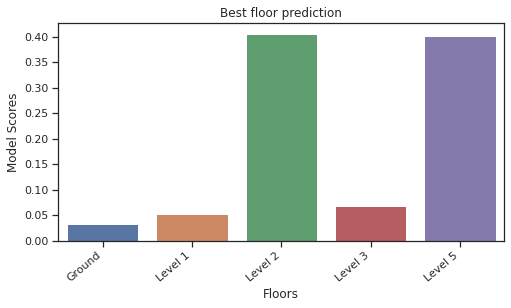

In [69]:
# 104/263
floor_scores = get_MR_scores_for_floors(floor_position='3',building_code='263', required_capacity = 0, penalty=0.005)
print(floor_scores)
plt.figure(figsize=(8,4))
ax = sns.barplot(x="Floor Name", y='scores', data=floor_scores);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(xlabel='Floors', ylabel='Model Scores')
ax.set_title("Best floor prediction")
plt.show()

In [ ]:
# 133/115
floor_scores = get_TO_scores_for_floors(floor_position='1',building_code='133',penalty=0.015)
print(floor_scores[['Floor Code','Floor Name','weights','probs','penalize','scores']])
plt.figure(figsize=(8,4))
ax = sns.barplot(x="Floor Name", y='scores', data=floor_scores);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(xlabel='Floors', ylabel='Model Scores')
ax.set_title("Best floor prediction")
plt.show()